# Causal Inference Experiment

This notebook demonstrates a causal inference experiment where we generate multiple instances from different causal variants. Each variant represents a different causal graph structure.

## Key Concepts:
- **N**: Total number of instances to generate
- **K**: Number of causal variants
- **Causal Graph**: A directed acyclic graph (DAG) that represents causal relationships
- **Intervention Variable (D)**: The decision or treatment variable
- **Outcome Variable (Y)**: The target variable we measure the causal effect on

## Import Required Libraries

First, we need to import the necessary libraries for our causal inference experiment.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import display
import sys
from typing import List, Dict, Tuple, Optional
import random

# Add the source directory to the path so we can import our functions
import sys
sys.path.append('/workspace/hub-shared-data/glorincz/dev/causal_inference/')

# Import our custom utility functions
from src.causal_utils import (
    generate_causal_graph, 
    generate_variant_graphs,
    simulate_data_from_graph,
    generate_dataset,
    visualize_causal_graph,
    calculate_causal_effect,
    calculate_true_causal_effect
)

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## Set Experiment Parameters

Here, we define the parameters for our causal inference experiment. You can adjust these parameters to control the experiment:

- `N`: Total number of instances to generate
- `K`: Number of causal variants
- `n_vars`: Number of variables in each causal graph
- `proportions`: Distribution of instances across variants (must sum to 1)

In [2]:
# Experiment parameters
N = 1000  # Total number of instances
K = 3     # Number of causal variants
n_vars = 8  # Number of variables in each causal graph

# Define the proportion of instances for each variant
# Default: equal distribution across variants
proportions = [1/K] * K
print(f"Generating {N} instances from {K} causal variants")
print(f"Each graph will have {n_vars} variables")
print(f"Variant proportions: {proportions}")

Generating 1000 instances from 3 causal variants
Each graph will have 8 variables
Variant proportions: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


## Variable Positioning

In our causal graphs, we position variables according to their role:

- Variables before the intervention (D) have the same structure within a variant
- The intervention variable (D) represents a decision or treatment
- The outcome variable (Y) is at the end of the causal chain
- The outcome may have:
  - A direct connection from D
  - A connection through mediator variables
  - No connection from D (no causal effect)

In [3]:
# Set intervention and outcome indices
intervention_idx = n_vars // 3  # Position D roughly in the first third
outcome_idx = n_vars - 1  # Position Y as the last variable

print(f"Intervention variable (D) is at index {intervention_idx}")
print(f"Outcome variable (Y) is at index {outcome_idx}")

Intervention variable (D) is at index 2
Outcome variable (Y) is at index 7


## Generate Causal Graphs for Each Variant

Now we'll generate K different causal graphs, one for each variant. Each graph will have the same number of variables but different causal relationships.

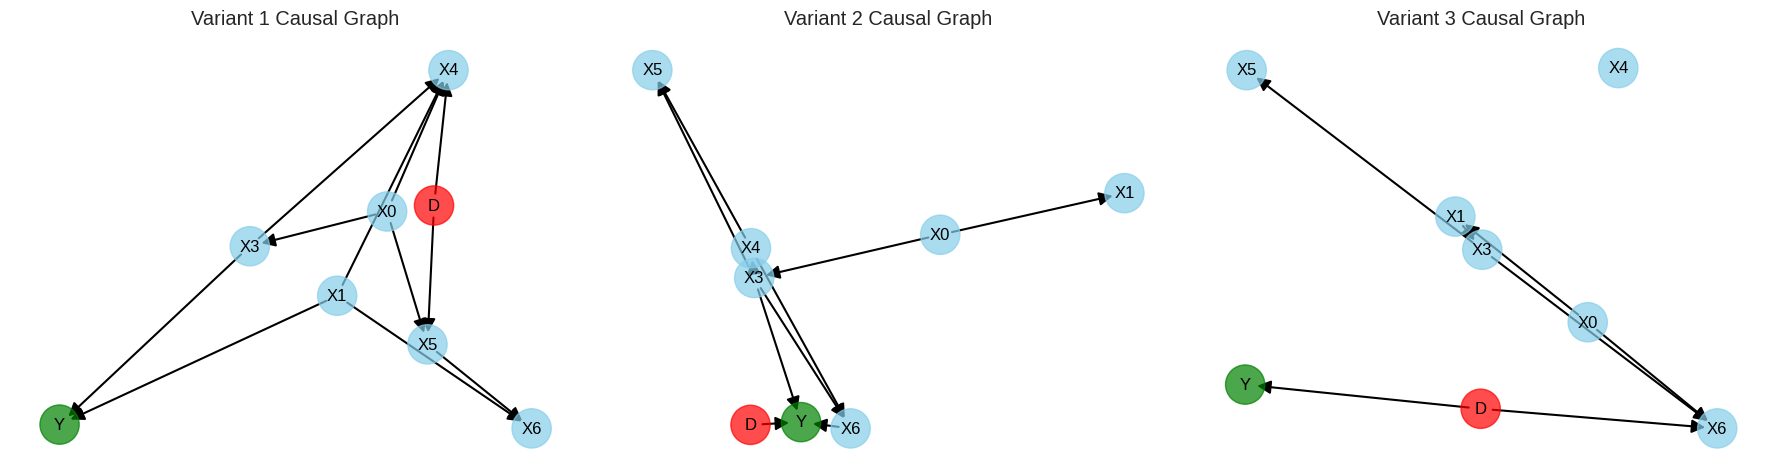

In [4]:
# Generate the variant graphs
variant_graphs = generate_variant_graphs(K, n_vars, intervention_idx, outcome_idx)

# Visualize each variant's causal graph
fig, axes = plt.subplots(1, K, figsize=(K*6, 5))
if K == 1:
    axes = [axes]  # Make it iterable for the case of K=1

for i, (graph, ax) in enumerate(zip(variant_graphs, axes)):
    visualize_causal_graph(graph, intervention_idx, outcome_idx, n_vars, ax=ax, 
                        title=f"Variant {i+1} Causal Graph")
    
plt.tight_layout()
plt.show()

## Analyze the Causal Paths

Let's analyze the causal paths from the intervention variable (D) to the outcome variable (Y) in each variant. This will help us understand the different causal structures.

In [5]:
def find_paths_from_d_to_y(G, d_idx, y_idx):
    """Find all paths from intervention D to outcome Y in a graph.
    
    Args:
        G: NetworkX DiGraph to analyze
        d_idx: Index of the intervention variable D
        y_idx: Index of the outcome variable Y
        
    Returns:
        List of paths from D to Y
    """
    try:
        # Use all_simple_paths to find all paths from d_idx to y_idx
        paths = list(nx.all_simple_paths(G, source=d_idx, target=y_idx))
        return paths
    except (nx.NetworkXNoPath, nx.NodeNotFound):
        return []

# Analyze causal paths for each variant
for i, graph in enumerate(variant_graphs):
    paths = find_paths_from_d_to_y(graph, intervention_idx, outcome_idx)
    
    print(f"Variant {i+1} causal paths from D to Y:")
    if not paths:
        print("  No causal path from D to Y")
    else:
        for j, path in enumerate(paths):
            # Format the path using variable names instead of indices
            path_str = " → ".join(["D" if node == intervention_idx else 
                                 "Y" if node == outcome_idx else 
                                 f"X{node}" for node in path])
            print(f"  Path {j+1}: {path_str}")
    print()

Variant 1 causal paths from D to Y:
  No causal path from D to Y

Variant 2 causal paths from D to Y:
  Path 1: D → Y

Variant 3 causal paths from D to Y:
  Path 1: D → Y



## Generate Dataset

Now we'll generate the full dataset with N instances distributed across K variants according to the specified proportions.

In [6]:
# Generate the dataset
data, variant_graphs, true_effects = generate_dataset(
    n=N, 
    k=K, 
    n_vars=n_vars, 
    proportions=proportions,
    intervention_idx=intervention_idx, 
    outcome_idx=outcome_idx
)

# Display the first few rows of the dataset
print(f"Dataset shape: {data.shape}")
display(data.head())

# Show the distribution of variants
variant_counts = data['variant_id'].value_counts().sort_index()
print("\nDistribution of variants:")
for variant_id, count in variant_counts.items():
    print(f"  Variant {variant_id}: {count} instances ({count/N:.1%})")

# Display the true causal effects for each variant
print("\nTrue Causal Effects:")
for variant_id, true_effect in enumerate(true_effects):
    print(f"  Variant {variant_id}: {true_effect:.4f}")
    
# Calculate weighted average true effect based on proportions
weighted_true_effect = sum(p * e for p, e in zip(proportions, true_effects))
print(f"  Overall (weighted): {weighted_true_effect:.4f}")

Dataset shape: (1000, 9)


,X0,X1,D,X3,X4,X5,X6,Y,variant_id
0,-0.093627,-0.121751,0.0,0.032569,-0.122450,-0.103751,0.070323,-0.273406,0
1,0.132851,-0.017072,0.0,0.155839,0.096465,0.139545,0.020727,0.223335,0
2,0.017315,0.102726,0.0,0.054664,0.072759,0.080367,0.123623,0.250772,0
3,0.097220,-0.100142,0.0,0.086193,-0.055713,0.074636,-0.245093,-0.144915,0
4,0.046879,0.172479,1.0,1.252971,1.584774,0.046396,0.040073,2.437538,0



Distribution of variants:
  Variant 0: 334 instances (33.4%)
  Variant 1: 333 instances (33.3%)
  Variant 2: 333 instances (33.3%)

True Causal Effects:
  Variant 0: 0.5242
  Variant 1: 1.2489
  Variant 2: 0.8616
  Overall (weighted): 0.8782


## Analyze Causal Effects

We'll analyze the causal effects of the intervention (D) on the outcome (Y) for each variant and for the overall dataset.

In [7]:
# Calculate overall causal effect
overall_effect = calculate_causal_effect(data)

print(f"Overall Causal Effect (all variants combined):")
print(f"  Effect estimate: {overall_effect['effect']:.4f}")
print(f"  Standard error: {overall_effect['std_error']:.4f}")
print(f"  p-value: {overall_effect['p_value']:.4f}")
print(f"  Treated mean (D=1): {overall_effect['treated_mean']:.4f}")
print(f"  Control mean (D=0): {overall_effect['control_mean']:.4f}")

# Calculate causal effect for each variant
print("\nCausal Effects by Variant:")
for variant_id in range(K):
    variant_data = data[data['variant_id'] == variant_id]
    effect = calculate_causal_effect(variant_data)
    
    print(f"\nVariant {variant_id}:")
    print(f"  Effect estimate: {effect['effect']:.4f}")
    print(f"  Standard error: {effect['std_error']:.4f}")
    print(f"  p-value: {effect['p_value']:.4f}")
    print(f"  Treated mean (D=1): {effect['treated_mean']:.4f}")
    print(f"  Control mean (D=0): {effect['control_mean']:.4f}")

Overall Causal Effect (all variants combined):
  Effect estimate: 2.0744
  Standard error: 0.0472
  p-value: -85.9163
  Treated mean (D=1): 2.0942
  Control mean (D=0): 0.0198

Causal Effects by Variant:

Variant 0:
  Effect estimate: 2.2036
  Standard error: 0.0421
  p-value: -102.7570
  Treated mean (D=1): 2.2355
  Control mean (D=0): 0.0319

Variant 1:
  Effect estimate: 3.1041
  Standard error: 0.0488
  p-value: -125.2164
  Treated mean (D=1): 3.0758
  Control mean (D=0): -0.0283

Variant 2:
  Effect estimate: 0.8415
  Standard error: 0.0384
  p-value: -41.8028
  Treated mean (D=1): 0.8943
  Control mean (D=0): 0.0527


## Visualize Treatment Effects

Let's visualize the treatment effects across different variants.

In [ ]:
# Prepare data for visualization
effect_data = []

# Overall effects
weighted_true_effect = sum(p * e for p, e in zip(proportions, true_effects))
effect_data.append({
    'Variant': 'All',
    'Effect': overall_effect['effect'],
    'Lower CI': overall_effect['effect'] - 1.96 * overall_effect['std_error'],
    'Upper CI': overall_effect['effect'] + 1.96 * overall_effect['std_error'],
    'True Effect': weighted_true_effect
})

# Per-variant effects
for variant_id in range(K):
    variant_data = data[data['variant_id'] == variant_id]
    effect = calculate_causal_effect(variant_data)
    
    effect_data.append({
        'Variant': f"Variant {variant_id}",
        'Effect': effect['effect'],
        'Lower CI': effect['effect'] - 1.96 * effect['std_error'],
        'Upper CI': effect['effect'] + 1.96 * effect['std_error'],
        'True Effect': true_effects[variant_id]
    })

# Convert to DataFrame for plotting
effect_df = pd.DataFrame(effect_data)

# Create the forest plot
plt.figure(figsize=(10, 6))
y_pos = range(len(effect_df))

# Plot estimated effects with confidence intervals
plt.errorbar(
    x=effect_df['Effect'],
    y=y_pos,
    xerr=np.array([
        effect_df['Effect'] - effect_df['Lower CI'],
        effect_df['Upper CI'] - effect_df['Effect']
    ]),
    fmt='o',
    capsize=5,
    elinewidth=2,
    markersize=8,
    label='Estimated Effect'
)

# Plot true effects as star markers
plt.scatter(
    effect_df['True Effect'],
    y_pos,
    marker='*',
    s=150,
    color='red',
    label='True Effect'
)

# Add vertical line at zero
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

plt.yticks(y_pos, effect_df['Variant'])
plt.xlabel('Causal Effect (D → Y)')
plt.title('Estimated vs True Causal Effects with 95% Confidence Intervals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Calculate accuracy metrics
effect_df['Bias'] = effect_df['Effect'] - effect_df['True Effect']
effect_df['Absolute Error'] = np.abs(effect_df['Bias'])
effect_df['Contains True'] = (effect_df['Lower CI'] <= effect_df['True Effect']) & (effect_df['True Effect'] <= effect_df['Upper CI'])

# Display accuracy table
print("\nEstimation Accuracy:")
print(f"  Mean Absolute Error: {effect_df['Absolute Error'].mean():.4f}")
print(f"  Coverage Rate (% of CIs containing true effect): {effect_df['Contains True'].mean()*100:.1f}%")

# Display the complete results table
print("\nComplete Results Table:")
display(effect_df[['Variant', 'True Effect', 'Effect', 'Bias', 'Lower CI', 'Upper CI', 'Contains True']])

## Interactive Parameter Settings

The following cell allows you to interactively change the experiment parameters and regenerate the results.

In [ ]:
from ipywidgets import interact, widgets

def run_experiment(N=1000, K=3, n_vars=8, equal_proportions=True):
    """Run the causal inference experiment with the given parameters.
    
    Args:
        N: Total number of instances
        K: Number of causal variants
        n_vars: Number of variables in each graph
        equal_proportions: Whether to use equal proportions for all variants
    """
    # Set random seed for reproducibility
    np.random.seed(42)
    random.seed(42)
    
    # Define proportions
    if equal_proportions:
        proportions = [1/K] * K
    else:
        # Generate random proportions that sum to 1
        raw_props = np.random.rand(K)
        proportions = raw_props / raw_props.sum()
    
    # Set intervention and outcome indices
    intervention_idx = n_vars // 3
    outcome_idx = n_vars - 1
    
    print(f"Running experiment with:")
    print(f"  N = {N} instances")
    print(f"  K = {K} variants")
    print(f"  {n_vars} variables per graph")
    print(f"  Proportions: {[round(p, 3) for p in proportions]}")
    print(f"  Intervention (D) at index {intervention_idx}")
    print(f"  Outcome (Y) at index {outcome_idx}")
    
    # Generate variant graphs
    variant_graphs = generate_variant_graphs(K, n_vars, intervention_idx, outcome_idx)
    
    # Calculate true causal effects
    true_effects = [calculate_true_causal_effect(g, intervention_idx, outcome_idx) for g in variant_graphs]
    weighted_true_effect = sum(p * e for p, e in zip(proportions, true_effects))
    
    # Display true effects
    print("\nTrue Causal Effects:")
    for variant_id, true_effect in enumerate(true_effects):
        print(f"  Variant {variant_id}: {true_effect:.4f}")
    print(f"  Overall (weighted): {weighted_true_effect:.4f}")
    
    # Generate dataset
    data, _, _ = generate_dataset(
        n=N, 
        k=K, 
        n_vars=n_vars, 
        proportions=proportions,
        intervention_idx=intervention_idx, 
        outcome_idx=outcome_idx
    )
    
    # Visualize graphs (up to 3 for readability)
    display_K = min(K, 3)
    fig, axes = plt.subplots(1, display_K, figsize=(display_K*6, 5))
    if display_K == 1:
        axes = [axes]
    
    for i, (graph, ax) in enumerate(zip(variant_graphs[:display_K], axes)):
        visualize_causal_graph(graph, intervention_idx, outcome_idx, n_vars, ax=ax, 
                            title=f"Variant {i+1} Causal Graph")
        
    plt.tight_layout()
    plt.show()
    
    # Calculate effects
    overall_effect = calculate_causal_effect(data)
    
    print(f"\nEstimated Overall Causal Effect: {overall_effect['effect']:.4f} (p-value: {overall_effect['p_value']:.4f})")
    print(f"True Overall Causal Effect: {weighted_true_effect:.4f}")
    print(f"Bias: {overall_effect['effect'] - weighted_true_effect:.4f}")
    
    # Show effects by variant
    effect_data = []
    
    # Overall effect
    effect_data.append({
        'Variant': 'All',
        'True Effect': weighted_true_effect,
        'Estimated Effect': overall_effect['effect'],
        'Lower CI': overall_effect['effect'] - 1.96 * overall_effect['std_error'],
        'Upper CI': overall_effect['effect'] + 1.96 * overall_effect['std_error'],
        'Bias': overall_effect['effect'] - weighted_true_effect
    })
    
    # Per-variant effects
    print("\nVariant-specific effects:")
    print(f"{'Variant':10} {'True':8} {'Estimated':10} {'Bias':8}")
    print(f"{'-'*40}")
    for variant_id in range(K):
        variant_data = data[data['variant_id'] == variant_id]
        effect = calculate_causal_effect(variant_data)
        
        bias = effect['effect'] - true_effects[variant_id]
        print(f"{variant_id:10} {true_effects[variant_id]:8.4f} {effect['effect']:10.4f} {bias:8.4f}")
        
        effect_data.append({
            'Variant': f"Variant {variant_id}",
            'True Effect': true_effects[variant_id],
            'Estimated Effect': effect['effect'],
            'Lower CI': effect['effect'] - 1.96 * effect['std_error'],
            'Upper CI': effect['effect'] + 1.96 * effect['std_error'],
            'Bias': bias
        })
    
    # Create visualization
    effect_df = pd.DataFrame(effect_data)
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    y_pos = range(len(effect_df))
    
    # Plot estimated effects with confidence intervals
    plt.errorbar(
        x=effect_df['Estimated Effect'],
        y=y_pos,
        xerr=np.array([
            effect_df['Estimated Effect'] - effect_df['Lower CI'],
            effect_df['Upper CI'] - effect_df['Estimated Effect']
        ]),
        fmt='o',
        capsize=5,
        elinewidth=2,
        markersize=8,
        label='Estimated Effect'
    )
    
    # Plot true effects
    plt.scatter(
        effect_df['True Effect'],
        y_pos,
        marker='*',
        s=150,
        color='red',
        label='True Effect'
    )
    
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    plt.yticks(y_pos, effect_df['Variant'])
    plt.xlabel('Causal Effect (D → Y)')
    plt.title('True vs Estimated Causal Effects')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Sample data
    print("\nSample data:")
    display(data.head())
    
    # Return the data for further analysis if needed
    return data, variant_graphs, true_effects

# Create interactive widgets
interact(
    run_experiment,
    N=widgets.IntSlider(min=100, max=10000, step=100, value=1000, description='N:'),
    K=widgets.IntSlider(min=1, max=10, step=1, value=3, description='K:'),
    n_vars=widgets.IntSlider(min=5, max=20, step=1, value=8, description='Variables:'),
    equal_proportions=widgets.Checkbox(value=True, description='Equal proportions')
);

## Conclusion

In this notebook, we've demonstrated a causal inference experiment where we:

1. Generated K different causal variants, each with a unique causal graph structure
2. Created a dataset with N instances distributed across these variants
3. Analyzed the causal effects of intervention D on outcome Y
4. Visualized the different causal structures and their effects

This framework allows us to explore how different causal structures can lead to different observed effects, even when the overall statistical patterns might appear similar. It highlights the importance of understanding the underlying causal mechanisms when analyzing data and making decisions.